In [3]:
# Library
import re
from unidecode import unidecode
import string
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from textblob import Word
import nltk
from nltk.tokenize import word_tokenize,MWETokenizer
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords as stopwords_scratch
from sklearn.feature_extraction.text import TfidfTransformer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from keras.models import load_model
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
import joblib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df= pd.read_csv('C:/Users/LENOVO\myproject/Tugas Platinum Binar Academy/dataset_platinum/train_preprocess.tsv (1).txt', sep='\t',names = ['data','label'],encoding='latin-1')
df

,data,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [8]:
def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

In [15]:
df['text_clean'] = df.data.apply(cleansing)

In [17]:
df.head()

,data,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung t...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kas...


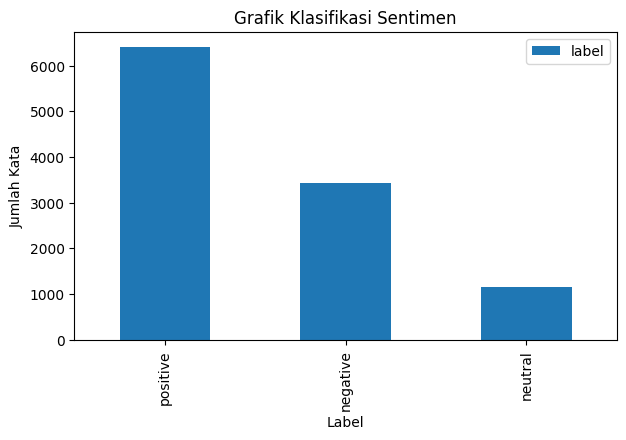

In [20]:
# Chart Klasifikasi Sentimen
df["label"].value_counts().plot.bar(figsize=(7,4))
plt.title('Grafik Klasifikasi Sentimen')
plt.xlabel('Label')
plt.ylabel('Jumlah Kata')
plt.legend()
plt.show()

In [21]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [22]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


In [24]:
import pickle

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [25]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


In [26]:
file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [27]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10,042,435
Trainable params: 10,042,435
Non-trainable params: 0
_________________________________________________________________


None
Epoch 1/10
880/880 [==============================] - 124s 138ms/step - loss: 0.4561 - accuracy: 0.8151 - val_loss: 0.3420 - val_accuracy: 0.8755
Epoch 2/10
880/880 [==============================] - 122s 138ms/step - loss: 0.1998 - accuracy: 0.9272 - val_loss: 0.3389 - val_accuracy: 0.8755
Epoch 3/10
880/880 [==============================] - 121s 137ms/step - loss: 0.1078 - accuracy: 0.9583 - val_loss: 0.4291 - val_accuracy: 0.8609
Epoch 3: early stopping


In [28]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 2s 17ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       685
           1       0.79      0.82      0.81       233
           2       0.92      0.88      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.83      0.85      0.84      2200
weighted avg       0.86      0.86      0.86      2200



In [29]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only    
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 2s 17ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       685
           1       0.78      0.82      0.80       233
           2       0.91      0.91      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.85      0.85      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 14ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       685
           1       0.76      0.81      0.78       233
           2       0.90      0.93      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 1s 15ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       685
           1       0.85      0.74      0.79       233
           2       0.93      0.87      0.90      1282

    accuracy                           0.86      2200
   macro avg       0.85      0.83      0.83      2200
weighted avg       0.87      0.86      0.86      2200



69/69 [==============================] - 3s 23ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       685
           1       0.83      0.76      0.80       233
           2       0.88      0.94      0.91      1282

    accuracy                           0.87      2200
   macro avg       0.86      0.83      0.84      2200
weighted avg       0.87      0.87      0.87      2200



69/69 [==============================] - 2s 29ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       685
           1       0.81      0.76      0.78       233
           2       0.90      0.93      0.92      1282

    accuracy                           0.88      2200
   macro avg       0.86      0.84      0.85      2200
weighted avg       0.88      0.88      0.88      2200




Rata-rata Accuracy:  0.8706363636363637


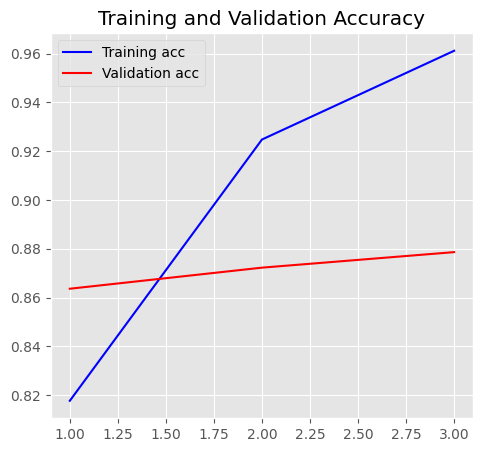

In [34]:
import matplotlib.pyplot as plt
plt.style.use ('ggplot')

def plot_history(history) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    

%matplotlib inline
plot_history(history)

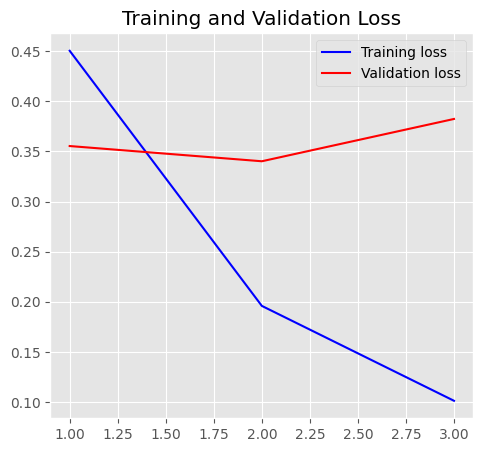

In [36]:
def plot_history(history) :
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [37]:
model.save('model.h5')
print("Model has created!")

Model has created!
